In [48]:
import os
import random
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
import shutil

In [49]:
INPUT_DIR = "/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/train"
OUTPUT_DIR = "/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/train_balanced"
TARGET_SIZE = 500
LOWER_LIMIT = 0.9 * TARGET_SIZE
UPPER_LIMIT = 1.1 * TARGET_SIZE

In [50]:
from collections import Counter
import matplotlib.pyplot as plt


def plot_class_distribution(data_folder):
    # Wczytanie danych
    data = datasets.ImageFolder(root=data_folder)
    class_names = data.classes

    # Zliczanie liczby wystąpień dla każdej klasy
    labels = [label for _, label in data]
    label_counts = Counter(labels)
    mapped_counts = {class_names[i]: count for i, count in label_counts.items()}

    # Tworzenie wykresu słupkowego
    plt.figure(figsize=(14, 6))
    plt.bar(mapped_counts.keys(), mapped_counts.values(), color="skyblue")

    # Dostosowanie etykiet
    plt.xlabel("Klasy")
    plt.ylabel("Liczba obrazów")
    plt.title("Rozkład danych na klasy")
    plt.xticks(rotation=45, ha="right", fontsize=9)
    plt.tight_layout()

    # Wyświetlanie wykresu
    plt.show()

    return mapped_counts

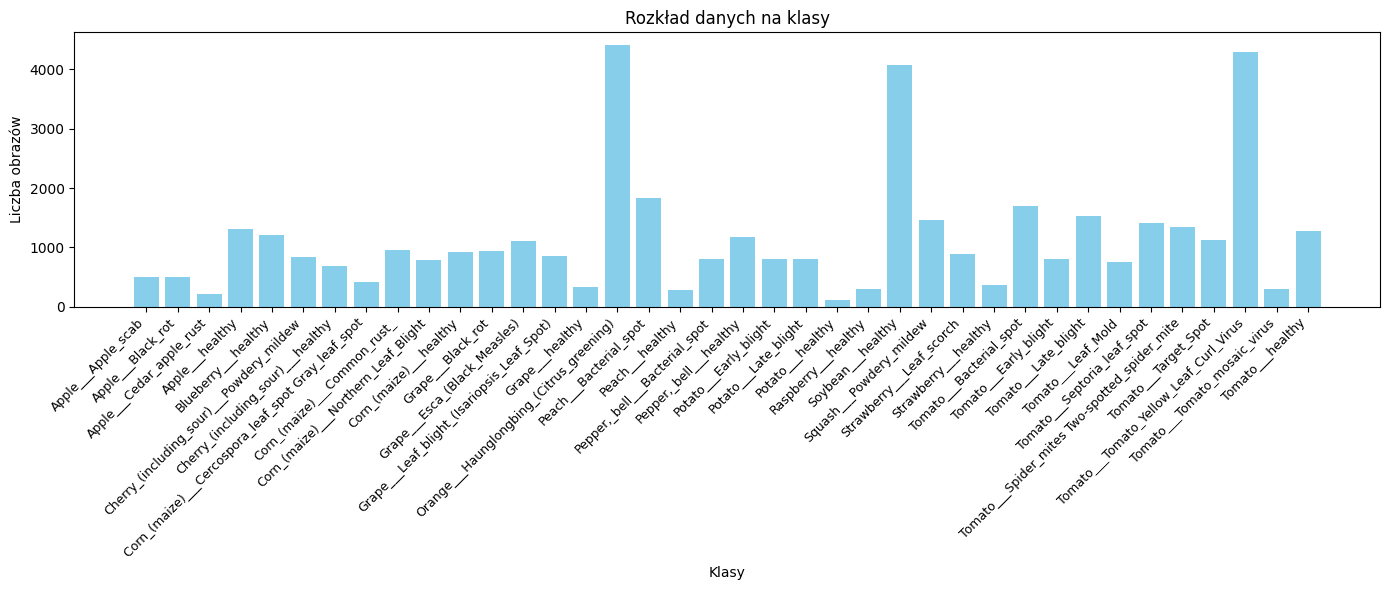

In [51]:
# data before balancing
mapped_counts = plot_class_distribution(INPUT_DIR)

In [52]:
# Transformacje augmentujące
augmentation = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.Resize((224, 224)),
    ]
)

In [53]:
# Wczytywanie i augmentacja
def augment_and_save(image_path, output_folder, count, start_idx=0):
    img = Image.open(image_path).convert("RGB")
    for i in range(count):
        augmented = augmentation(img)
        filename = f"aug_{start_idx + i}_{os.path.basename(image_path)}"
        augmented.save(os.path.join(output_folder, filename))

In [54]:
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)

for class_name in os.listdir(INPUT_DIR):
    class_path = os.path.join(INPUT_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    output_class_path = os.path.join(OUTPUT_DIR, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    images = [
        f for f in os.listdir(class_path) if f.lower().endswith(("jpg", "jpeg", "png"))
    ]
    n_images = len(images)

    if LOWER_LIMIT <= n_images <= UPPER_LIMIT:
        # Klasa jest już w dobrym zakresie – kopiuj bez zmian (lub tylko resize)
        for img_name in images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(output_class_path, img_name)
            Image.open(src).convert("RGB").resize((224, 224)).save(dst)

    elif n_images > UPPER_LIMIT:
        class_size = random.randint(int(LOWER_LIMIT), int(UPPER_LIMIT))
        sampled = random.sample(images, class_size)
        for img_name in sampled:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(output_class_path, img_name)
            Image.open(src).convert("RGB").resize((224, 224)).save(dst)
    else:
        # Skopiuj wszystkie oryginalne
        for img_name in images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(output_class_path, img_name)
            Image.open(src).convert("RGB").resize((224, 224)).save(dst)

        # Augmentuj brakujące
        deficit = TARGET_SIZE - n_images
        for i in tqdm(range(deficit), desc=f"Augmenting {class_name}"):
            img_name = random.choice(images)
            augment_and_save(
                os.path.join(class_path, img_name),
                output_class_path,
                count=1,
                start_idx=i,
            )

Augmenting Raspberry___healthy: 100%|██████████| 203/203 [00:00<00:00, 746.38it/s]
Augmenting Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 100%|██████████| 90/90 [00:00<00:00, 861.24it/s]
Augmenting Potato___healthy: 100%|██████████| 379/379 [00:00<00:00, 874.31it/s]


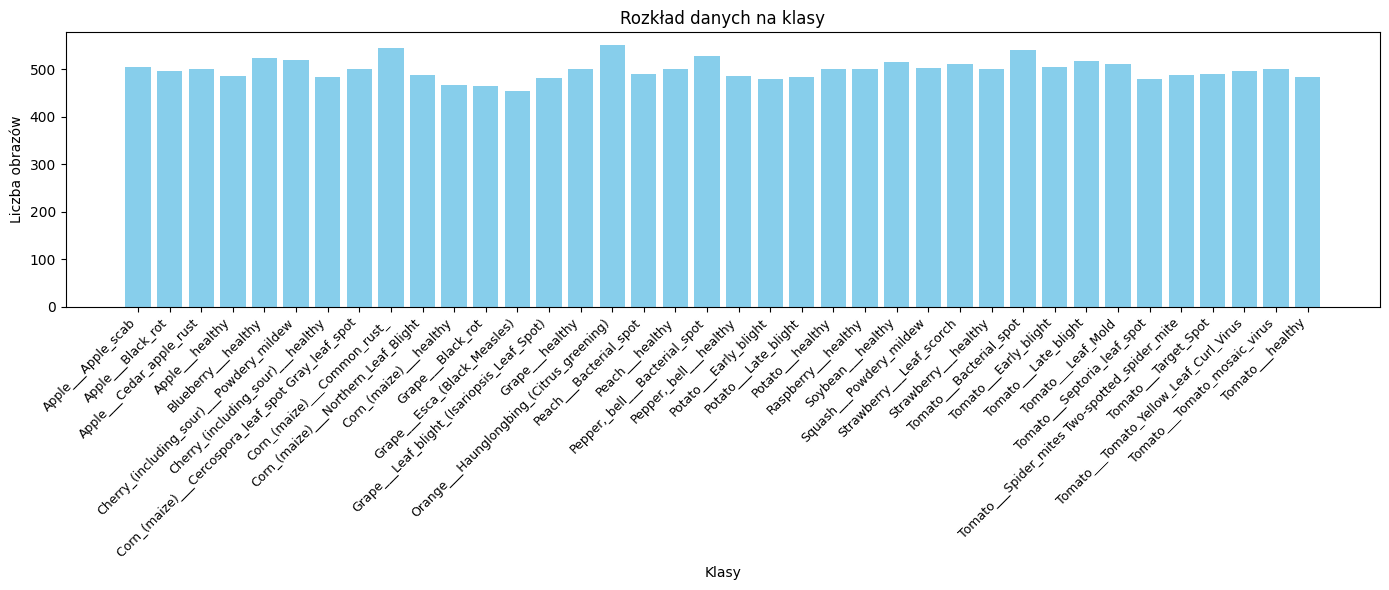

In [55]:
# data after balancing
mapped_counts_after = plot_class_distribution(OUTPUT_DIR)